<b>EDA - Exploratory Data Analysis</b>

This notebook performs exploratory data analysis on the brain MRI segmentation dataset.


In [2]:
### IMPORTS ###
# enable autoreload
%load_ext autoreload
%autoreload 2
import sys, os
import matplotlib.pyplot as plt
from pathlib import Path

ROOT = Path(os.getcwd()).parent.resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.utils.eda import gather_stats, plot_distributions
import matplotlib.pyplot as plt
from src.dataloader.dataloader import base_transforms

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/herminea/.local/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
2025-04-28 16:16:37.176546: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-28 16:16:37.201264: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available

First 5 cases:


,patient,dim_x,dim_y,num_slices,mean_int,std_int,min_int,max_int,slices_with_tumor,class0_vox,class1_vox,class2_vox,pct_tumor
0,10,512,512,75,39.818808,58.527517,0.0,422.0,22,19633933,8009,18858,0.136653
1,101,512,512,82,36.267281,57.631325,0.0,428.0,33,21470258,3051,22499,0.118860
2,103,512,512,74,23.574337,36.608725,0.0,410.0,34,19353358,8277,37021,0.233511
3,107,512,512,65,47.189194,67.326711,0.0,387.0,18,17033700,0,5660,0.033217
4,109,512,512,67,32.654710,52.548908,0.0,411.0,30,17543079,4665,15904,0.117111


Summary stats:


,dim_x,dim_y,num_slices,mean_int,std_int,min_int,max_int,slices_with_tumor,class0_vox,class1_vox,class2_vox,pct_tumor
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.0,130.000000,130.000000,1.300000e+02,130.000000,130.000000,130.000000
mean,522.953846,522.461538,84.792308,44.700194,99.276183,0.0,1465.053071,34.330769,2.347586e+07,18085.015385,24906.938462,0.198465
std,30.929994,31.355465,23.667168,28.999147,90.925934,0.0,2064.008160,18.201452,8.846294e+06,18534.333119,35275.402917,0.184329
min,512.000000,480.000000,57.000000,15.997856,29.151160,0.0,346.000000,7.000000,1.489171e+07,0.000000,0.000000,0.005772
25%,512.000000,512.000000,70.000000,32.288586,57.396362,0.0,414.250000,24.000000,1.838566e+07,5561.500000,3869.750000,0.076183
50%,512.000000,512.000000,76.000000,42.854076,64.395598,0.0,465.500000,30.000000,2.013281e+07,11125.000000,16323.000000,0.152454
75%,512.000000,512.000000,85.750000,49.787347,74.510010,0.0,858.750000,39.000000,2.600783e+07,26021.750000,34651.250000,0.263893
max,640.000000,640.000000,162.000000,329.910145,524.900364,0.0,9887.296875,105.000000,6.632089e+07,87054.000000,299865.000000,1.200418


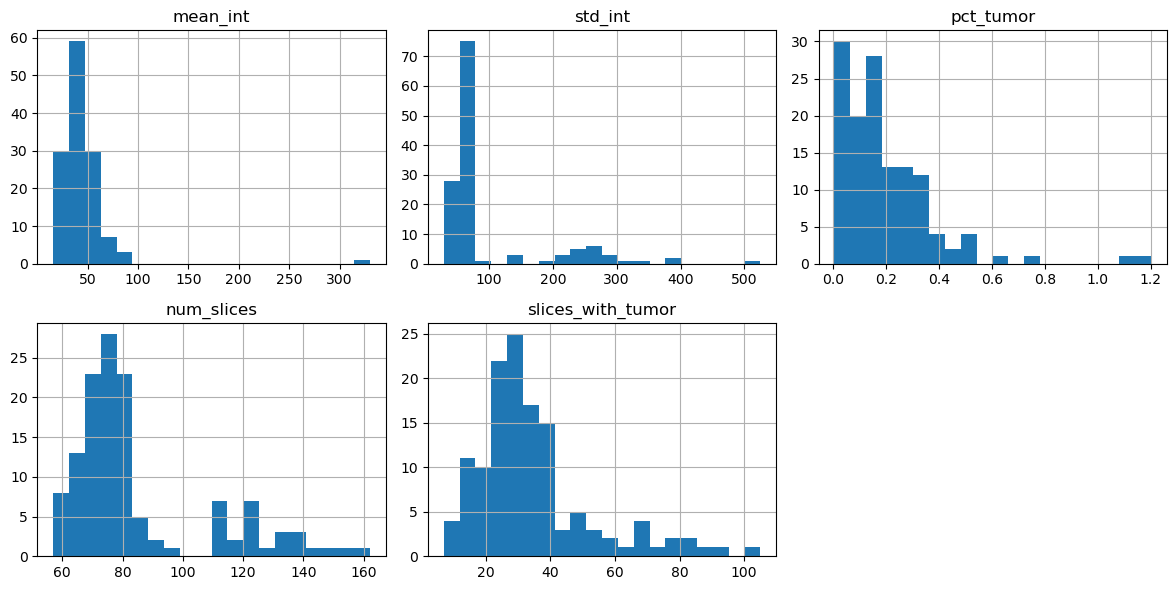

In [3]:
DATA_DIR = "/datasets/tdt4265/mic/open/HNTS-MRG"
df = gather_stats(DATA_DIR)
print("First 5 cases:")
display(df.head())
print("Summary stats:")
display(df.describe())

# Plot all histograms at once:
plot_distributions(df)


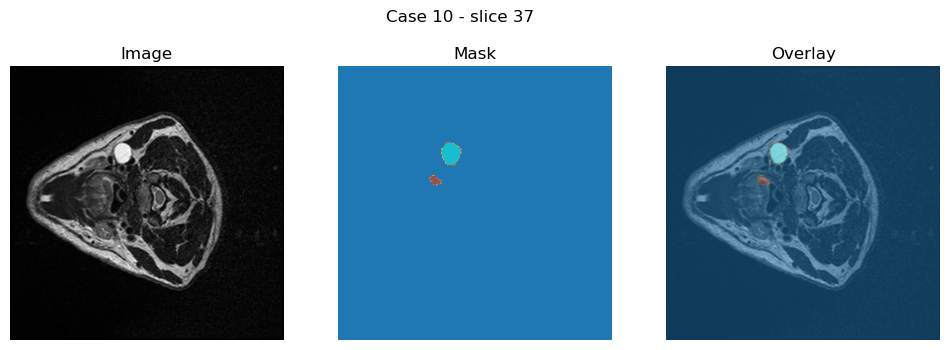

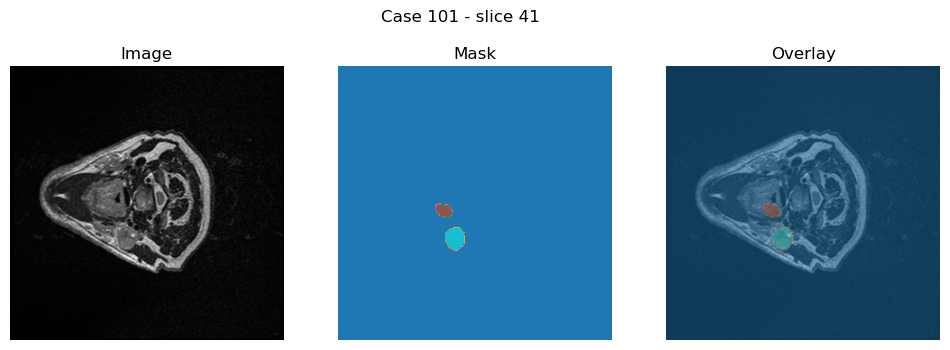

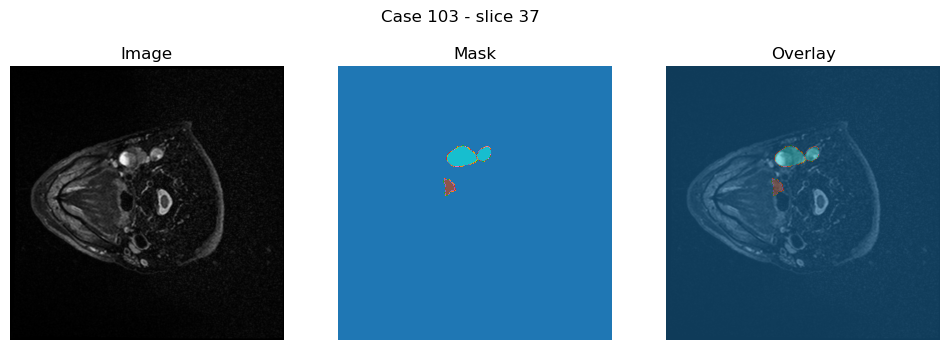

In [6]:
import nibabel as nib

for i, case in enumerate(df["patient"].tolist()[:3]):
    preRT = os.path.join(DATA_DIR, "train", case, "preRT")
    img_file  = next(Path(preRT).glob("*T2.nii.gz"))
    mask_file = next(Path(preRT).glob("*mask.nii.gz"))

    img = nib.load(str(img_file)).get_fdata()
    lbl = nib.load(str(mask_file)).get_fdata()

    mid = img.shape[2] // 2
    fig, axes = plt.subplots(1,3, figsize=(12,4))
    axes[0].imshow(img[:,:,mid], cmap="gray");            axes[0].set_title("Image")
    axes[1].imshow(lbl[:,:,mid], cmap="tab10");           axes[1].set_title("Mask")
    axes[2].imshow(img[:,:,mid], cmap="gray")
    axes[2].imshow(lbl[:,:,mid], cmap="tab10", alpha=0.5); axes[2].set_title("Overlay")
    for ax in axes: ax.axis("off")
    plt.suptitle(f"Case {case} - slice {mid}")
    plt.show()



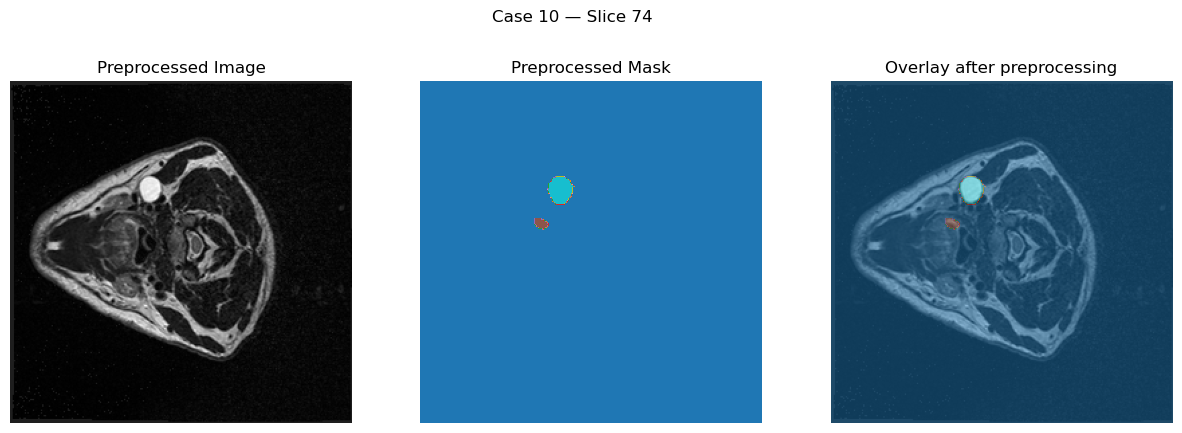

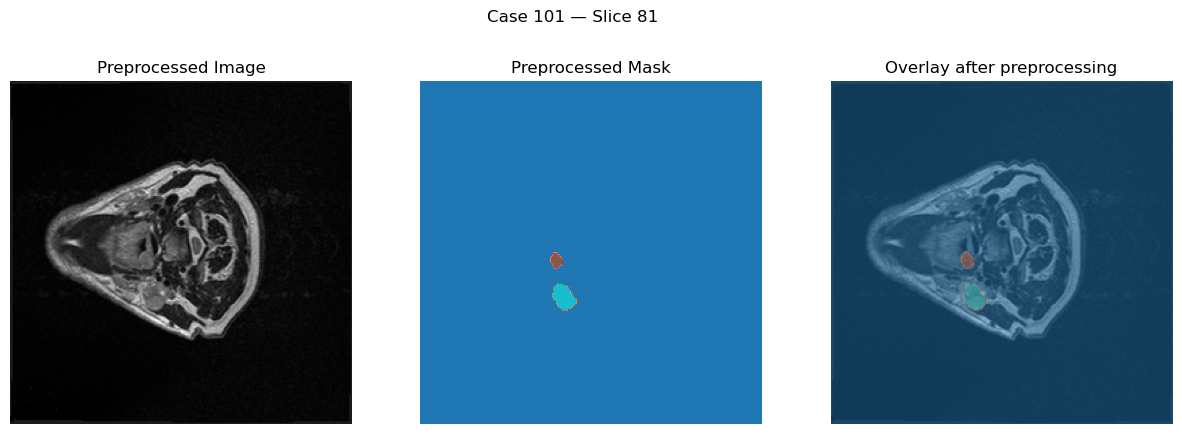

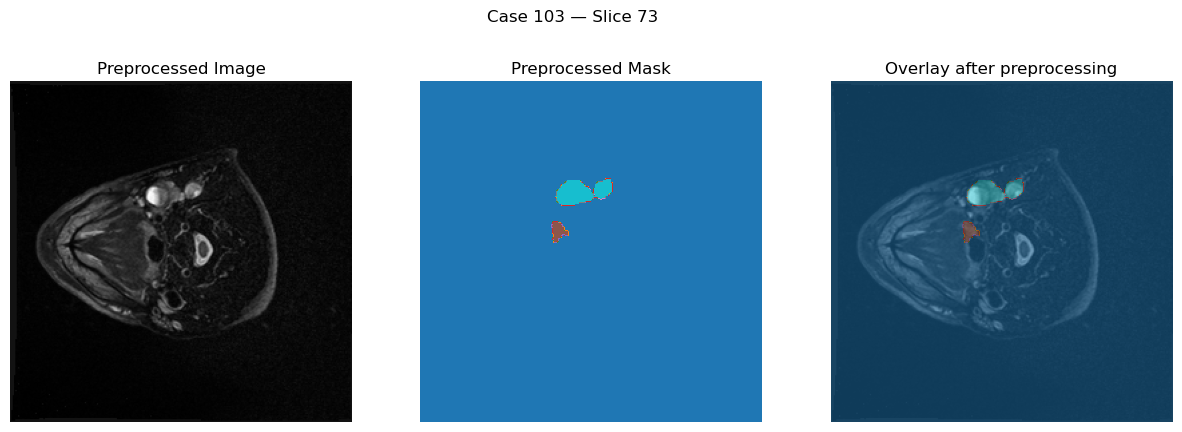

In [ ]:
### Visualize post preprocessed data
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Spacingd, CropForegroundd, NormalizeIntensityd
import matplotlib.pyplot as plt
from pathlib import Path
import os

# 1) Build a Compose that matches your dataloader's base_transforms()
qc_transform = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Spacingd(
        keys=["image", "label"],
        pixdim=(1.0, 1.0, 1.0),
        mode=("bilinear","nearest"),
    ),
    CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
    NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
])

def qc_overlay_case(data_dir: str, case_id: str, slice_idx: int = None):
    """Apply qc_transform to (image, label) and plot the mid‐slice overlay."""
    preRT = Path(data_dir) / "train" / case_id / "preRT"
    img_file  = next(preRT.glob("*T2.nii.gz"))
    mask_file = next(preRT.glob("*mask.nii.gz"))
    sample = {"image": str(img_file), "label": str(mask_file)}

    # 2) apply the Compose pipeline
    out = qc_transform(sample)
    img = out["image"][0]   # (1,H,W,D) → squeeze channel
    lbl = out["label"][0]

    # pick center slice if none given
    D = img.shape[2]
    if slice_idx is None:
        slice_idx = D // 2
    

    # 3) plot
    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    axes[0].imshow(img[:,:,slice_idx], cmap="gray")
    axes[0].set_title("Preprocessed Image")
    axes[1].imshow(lbl[:,:,slice_idx], cmap="tab10")
    axes[1].set_title("Preprocessed Mask")
    axes[2].imshow(img[:,:,slice_idx], cmap="gray")
    axes[2].imshow(lbl[:,:,slice_idx], cmap="tab10", alpha=0.5)
    axes[2].set_title("Overlay after preprocessing")
    for ax in axes:
        ax.axis("off")
    plt.suptitle(f"Case {case_id} — Slice {slice_idx}")
    plt.show()

# Usage
DATA_DIR = "/datasets/tdt4265/mic/open/HNTS-MRG"
from src.utils.eda import gather_stats   # or wherever gather_stats lives
df = gather_stats(DATA_DIR)
for case in df["patient"].tolist()[:3]:
    qc_overlay_case(DATA_DIR, case)
